In [1]:
#import all libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import html
import matplotlib.pyplot as plt
import seaborn as sns 
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display
from ipywidgets import interact, interact_manual
import re

In [2]:
#Scrape the html behind the covid url saved in the "r" variable
r = requests.get('http://www.worldometers.info/coronavirus/')
soup = BeautifulSoup(r.text,'lxml')

In [31]:
#Create list that saves only whats needed to build the dataframe i.e, the "td" tags
lst_crucial = [str(i) for i in list(soup.find_all('table')[0].find_all('td'))]

## Reusable Functions

In [163]:
#Function to create dataframe
#First find the pattern throughout the list where the real data lies
#The pattern suggests that the 13 lines until the line with "world popluation" is where all our column data's at
#Countries column: simple regex extracting data between > and < from the list using re.findall
#Giving a range of indices to look at within the list and then selecting relevant elements for each column
def create_df():
    df = pd.DataFrame()
    df['Countries'] = [''.join([re.findall('>(.*?)<', lst_crucial[i-13:i+1][0])[1]]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['Total_cases'] = [''.join([k for s in lst_crucial[i-13:i+1][1] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['New_cases'] = [''.join([k for s in lst_crucial[i-13:i+1][2] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['Total_deaths'] = [''.join([k for s in lst_crucial[i-13:i+1][3] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['New_deaths'] = [''.join([k for s in lst_crucial[i-13:i+1][4] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['Total_recovered'] = [''.join([k for s in lst_crucial[i-13:i+1][5] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['New_recovered'] = [''.join([k for s in lst_crucial[i-13:i+1][6] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['Active_cases'] = [''.join([k for s in lst_crucial[i-13:i+1][7] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['Serious_critical'] = [''.join([k for s in lst_crucial[i-13:i+1][8] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['Cases_1m'] = [''.join([k for s in lst_crucial[i-13:i+1][9] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['Deaths_1m'] = [''.join([k for s in lst_crucial[i-13:i+1][10] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['Total_tests'] = [''.join([k for s in lst_crucial[i-13:i+1][11] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['Tests_1m'] = [''.join([k for s in lst_crucial[i-13:i+1][12] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    df['Total_population'] = [''.join([k for s in lst_crucial[i-13:i+1][13] for k in s if k.isdigit()]) for i,v in enumerate(lst_crucial) if 'world-population' in v]
    return df 

In [159]:
#Create a function taking in the previously created dataframe as an argument
#Convert all relevant columns to int/float format, in this case all but Countries column
#Add some interesting columns such as the ones created below. I can think of some more but let's stick to this for now
def polish(df):
    df[['Total_cases', 'New_cases', 'Total_deaths', 'New_deaths',
       'Total_recovered', 'New_recovered', 'Active_cases', 'Serious_critical', 'Cases_1m',
       'Deaths_1m', 'Total_tests', 'Tests_1m', 'Total_population']] = df.loc[ : , df.columns != 'Countries'].apply(pd.to_numeric).astype('Int64')
    df['Case_by_pop%'] = (df['Total_cases']/df['Total_population'])*100
    df['Death_by_pop%'] = (df['Total_deaths']/df['Total_population'])*100
    df['Recovery_by_pop%'] = (df['Total_recovered']/df['Total_population'])*100
    df['Test_by_pop%'] = (df['Total_tests']/df['Total_population'])*100
    df['Death_by_case%'] = (df['Total_deaths']/df['Total_cases'])*100
    df['Active_by_case%'] = (df['Active_cases']/df['Total_cases'])*100
    return df

In [216]:
#Some interesting insights into Countries that are top ten in Mortality rate, Testing, Recovery, Cases etc
#Thought it might be interesting to look at what percent owes to covid deaths in each country out of overall cases
#Interesting to note that Total Cases = Total Recovered + Total Deaths + Active Cases. So the data is pretty accurate
#Adding to the above point, if the left wasn't equal to the right, there would be some of missing persons to account for
#Testing is obviously not restricted to one record per person hence overshooting 100% sometimes. One person may have done 500 tests and that would still be recored
#But it might still be an indication of ease of availability of testing resources
#Activity shows how much percent of total cases is today's cases
def analysis(df):
    df_melted = df.melt(id_vars=['Countries'], 
        var_name="Statistic_type", 
        value_name="Stats").sort_values(by=['Countries'])
    Mortality_top = df.loc[df['Death_by_case%'] > 5].sort_values(by=['Death_by_case%'], ascending = False)
    Mortality_by_pop_top = df.loc[df['Death_by_pop%'] > 0.1].sort_values(by=['Death_by_pop%'], ascending = False)
    Testing_top = df.loc[df['Test_by_pop%'] > 150].sort_values(by=['Test_by_pop%'], ascending = False)
    Recovery_top = df.loc[df['Recovery_by_pop%'] > 5].sort_values(by=['Recovery_by_pop%'], ascending = False)
    Cases_top = df.loc[df['Case_by_pop%'] > 7].sort_values(by=['Case_by_pop%'], ascending = False)
    Active_top = df.loc[df['Active_by_case%'] > 50].sort_values(by=['Active_by_case%'], ascending = False)
    df1 = df.copy()
    df1.set_index('Countries', inplace = True)
    dct_min_max = {'Case_by_pop': {'max': (df1['Case_by_pop%'].max(), df1['Case_by_pop%'].idxmax()), 'min': (df1['Case_by_pop%'].min(), df1['Case_by_pop%'].idxmin())},
                    'Death_by_pop': {'max': (df1['Death_by_pop%'].max(), df1['Death_by_pop%'].idxmax()), 'min': (df1['Death_by_pop%'].min(), df1['Death_by_pop%'].idxmin())},
                    'Recovery_by_pop': {'max': (df1['Recovery_by_pop%'].max(), df1['Recovery_by_pop%'].idxmax()), 'min': (df1['Recovery_by_pop%'].min(), df1['Recovery_by_pop%'].idxmin())},
                    'Test_by_pop': {'max': (df1['Test_by_pop%'].max(), df1['Test_by_pop%'].idxmax()), 'min': (df1['Test_by_pop%'].min(), df1['Test_by_pop%'].idxmin())},
                    'Death_by_case': {'max': (df1['Death_by_case%'].max(), df1['Death_by_case%'].idxmax()), 'min': (df1['Death_by_case%'].min(), df1['Death_by_case%'].idxmin())},
                    'Active_by_case': {'max': (df1['Active_by_case%'].max(), df1['Active_by_case%'].idxmax()), 'min': (df1['Active_by_case%'].min(), df1['Active_by_case%'].idxmin())}}
    
    return display(df_melted, Mortality_top, Mortality_by_pop_top, Testing_top, Recovery_top, Cases_top, Active_top, dct_min_max
    )

In [251]:
def visualize(df):
    # create figure and axis objects with subplots()
    g1 = df.loc[df['Case_by_pop%'] > 5.0]
    fig,ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (20,5)
    plt.xticks(rotation=45)
    # make a plot
    s1 = ax.plot(g1['Countries'], g1['Case_by_pop%'], color="blue", label = 'Case % by population', marker="o")
    s2 = ax.plot(g1['Countries'], g1['Recovery_by_pop%'], color="green", label = 'Recovery % by population', marker="o")
    plt.legend()
    # set x-axis label
    ax.set_xlabel("Country",fontsize=14)
    # set y-axis label
    ax.set_ylabel("Cases and Recovery percentage by population", color='blue', fontsize=14)
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    s3 = ax2.plot(g1['Countries'], g1["Death_by_pop%"], color = "red", label = 'Death % by population', marker = "o")
    ax2.set_ylabel("Mortality by population",color="red",fontsize=14)
    plt.show()
    
    # Death, recovery and case percentages for top 10 countries based on total case percentage by population
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
    axs[0].bar(df.loc[df['Case_by_pop%'] > 6.0]['Countries'], df.loc[df['Case_by_pop%'] > 6.0]['Case_by_pop%'])
    axs[0].tick_params(labelrotation=45)
    axs[1].bar(df.loc[df['Case_by_pop%'] > 6.0]['Countries'], df.loc[df['Case_by_pop%'] > 6.0]['Recovery_by_pop%'], color = 'green')
    axs[1].tick_params(labelrotation=45)
    ax2 = axs[2].twinx()
    ax2.bar(df.loc[df['Case_by_pop%'] > 6.0]['Countries'], df.loc[df['Case_by_pop%'] > 6.0]['Death_by_pop%'], color = 'red')
    axs[2].tick_params(labelrotation=45)
    fig.suptitle('Cases-Recovery-Death percentages by country population - top fifteen in cases ')

In [270]:
#Comparing Active cases with Total, Death and Recovery percents
#Considering only top fifteen in deaths by case countries
def active_cases(df):
    g2 = df.sort_values(by=['Death_by_case%'], ascending = False).head(20)
    fig,ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (20,5)
    plt.xticks(rotation=45)
    s4 = ax.plot(g2['Countries'], g2['Case_by_pop%'], color="orange", label = 'Case % by population', marker = "o")
    s5 = ax.plot(g2['Countries'], g2['Recovery_by_pop%'], color="green", label = 'Recovery % by population', marker = "o")
    plt.legend()
    ax.set_xlabel("Country",fontsize=14)
    ax.set_ylabel("Cases-Recovery % by Total Population",fontsize=14)
    ax2=ax.twinx()
    s6 = ax2.plot(g2['Countries'], g2["Death_by_case%"], color = "black", label = 'Death % by Total Cases', marker = "o")
    s7 = ax2.plot(g2['Countries'], g2["Active_by_case%"], color = "red", label = 'Active Case % by Total Cases', marker = "o")
    ax2.set_ylabel("Activity-Mortality % by Total Cases",color="red",fontsize=14)
    plt.show()
#How about the availability of testing reources in these countries with much deaths?
#Note that its not possible to determine actual test% by population with this data as it is not in one record per person basis
#But it can still be useful to determine the availibility of these resources
    g2.plot('Countries',[17,18],kind = 'bar', color=("orange","black"),figsize=(20,7))
#What about countries where testing is high vs where its low? Is there a clear disparity?
    g3 = df.loc[df['Test_by_pop%'] < 5.0].sort_values(by=['Test_by_pop%'], ascending = True).head(15)
    g4 = df.loc[df['Test_by_pop%'] > 100].sort_values(by=['Test_by_pop%'], ascending = False).head(15)
    fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
    axs[0].bar(g3['Countries'], g3['Test_by_pop%'], color = 'orange')
    axs[0].tick_params(labelrotation=45)
    ax2 = axs[1].twinx()
    ax2.bar(g4['Countries'], g4['Test_by_pop%'], color = 'green')
    axs[1].tick_params(labelrotation=45)
    fig.suptitle('Countries with ample resources VS countries without')

## Analysis and Visuals

In [165]:
df = create_df()

In [166]:
polish(df)

,Countries,Total_cases,New_cases,Total_deaths,New_deaths,Total_recovered,New_recovered,Active_cases,Serious_critical,Cases_1m,Deaths_1m,Total_tests,Tests_1m,Total_population,Case_by_pop%,Death_by_pop%,Recovery_by_pop%,Test_by_pop%,Death_by_case%,Active_by_case%
0,USA,26911375,<NA>,454213,<NA>,16629530,<NA>,9827632,23860,81023,1368,314195168,945956,332145637,8.102282,0.136751,5.006698,94.595603,1.687810,36.518506
1,India,10767206,<NA>,154522,<NA>,10448406,869000956,164278,8944,7757,111,197752057,142475,1387975211,0.775749,0.011133,0.752780,14.247521,1.435117,1.525725
2,Brazil,9230016,<NA>,225143,<NA>,8077967,<NA>,926906,8318,43242,1055,28600000,133990,213448530,4.324235,0.105479,3.784503,13.399015,2.439248,10.042301
3,Russia,3884730,16643,74158,539,3340545,86900022372,470027,2300,26613,508,102500000,702192,145971424,2.661295,0.050803,2.288492,70.219223,1.908961,12.099348
4,UK,3835783,<NA>,106564,<NA>,1767972,<NA>,1961247,3832,56329,1565,73448821,1078606,68096079,5.632898,0.156491,2.596290,107.860573,2.778155,51.130291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Wallis and Futuna,5,<NA>,<NA>,<NA>,4,<NA>,1,<NA>,450,<NA>,1202,108074,11122,0.044956,NaN,0.035965,10.807409,NaN,20.000000
211,Marshall Islands,4,<NA>,<NA>,<NA>,4,<NA>,0,<NA>,67,<NA>,<NA>,<NA>,59425,0.006731,NaN,0.006731,NaN,NaN,0.000000
212,Samoa,2,<NA>,<NA>,<NA>,2,<NA>,0,<NA>,10,<NA>,<NA>,<NA>,199190,0.001004,NaN,0.001004,NaN,NaN,0.000000
213,Micronesia,1,<NA>,<NA>,<NA>,1,<NA>,0,<NA>,9,<NA>,<NA>,<NA>,115731,0.000864,NaN,0.000864,NaN,NaN,0.000000


In [217]:
analysis(df)

,Countries,Statistic_type,Stats
522,Afghanistan,Total_deaths,2406
2242,Afghanistan,Total_tests,254515
1597,Afghanistan,Serious_critical,957
3532,Afghanistan,Test_by_pop%,0.645334
3747,Afghanistan,Death_by_case%,4.36075
...,...,...,...
1820,Zimbabwe,Cases_1m,2238
1390,Zimbabwe,Active_cases,5731
3970,Zimbabwe,Active_by_case%,17.083
3325,Zimbabwe,Recovery_by_pop%,0.177342


,Countries,Total_cases,New_cases,Total_deaths,New_deaths,Total_recovered,New_recovered,Active_cases,Serious_critical,Cases_1m,Deaths_1m,Total_tests,Tests_1m,Total_population,Case_by_pop%,Death_by_pop%,Recovery_by_pop%,Test_by_pop%,Death_by_case%,Active_by_case%
165,Yemen,2122,<NA>,615,<NA>,1426,<NA>,81,23,70,20,17404,576,30208908,0.007024,0.002036,0.004720,0.057612,28.982092,3.817154
209,Western Sahara,10,<NA>,1,<NA>,8,<NA>,1,<NA>,17,2,<NA>,<NA>,605886,0.001650,0.000165,0.001320,NaN,10.000000,10.000000
12,Mexico,1869708,5448,159100,564,1425748,86900013355,284860,5692,14412,1226,4711197,36316,129728251,1.441250,0.122641,1.099027,3.631589,8.509350,15.235534
208,Montserrat,13,<NA>,1,<NA>,12,<NA>,0,<NA>,2603,200,626,125350,4994,0.260312,0.020024,0.240288,12.535042,7.692308,0.000000
106,Sudan,27273,<NA>,1812,<NA>,21504,<NA>,3957,<NA>,614,41,<NA>,<NA>,44445579,0.061363,0.004077,0.048383,NaN,6.643934,14.508855
124,Syria,14096,<NA>,926,<NA>,7644,<NA>,5526,<NA>,794,52,<NA>,<NA>,17748122,0.079422,0.005217,0.043069,NaN,6.569240,39.202611
45,Ecuador,250986,<NA>,14890,<NA>,209814,<NA>,26282,525,14100,837,885962,49773,17799926,1.410040,0.083652,1.178735,4.977335,5.932602,10.471500
187,Isle of Man,434,<NA>,25,<NA>,398,<NA>,11,1,5088,293,27870,326737,85298,0.508804,0.029309,0.466599,32.673685,5.760369,2.534562
61,Egypt,166492,<NA>,9360,<NA>,130107,<NA>,27025,90,1609,90,1000000,9665,103461917,0.160921,0.009047,0.125754,0.966539,5.621892,16.232011


,Countries,Total_cases,New_cases,Total_deaths,New_deaths,Total_recovered,New_recovered,Active_cases,Serious_critical,Cases_1m,Deaths_1m,Total_tests,Tests_1m,Total_population,Case_by_pop%,Death_by_pop%,Recovery_by_pop%,Test_by_pop%,Death_by_case%,Active_by_case%
154,Gibraltar,4128,<NA>,78,<NA>,3745,<NA>,305,27,122547,2316,158603,4708416,33685,12.254713,0.231557,11.117708,470.841621,1.889535,7.388566
160,San Marino,3025,<NA>,67,<NA>,2723,<NA>,235,7,89041,1972,34271,1008772,33973,8.904130,0.197215,8.015189,100.877167,2.214876,7.768595
25,Belgium,711417,1264,21124,32,49061,86900052,641232,315,61227,1818,8275416,712210,11619351,6.122691,0.181800,0.422235,71.220983,2.969285,90.134478
59,Slovenia,168455,1619,3541,19,147687,8690001684,17227,168,81023,1703,809494,389347,2079107,8.102277,0.170314,7.103386,38.934696,2.102045,10.226470
4,UK,3835783,<NA>,106564,<NA>,1767972,<NA>,1961247,3832,56329,1565,73448821,1078606,68096079,5.632898,0.156491,2.596290,107.860573,2.778155,51.130291
19,Czechia,994514,7117,16545,63,885279,869000528,92690,988,92766,1543,6244289,582451,10720707,9.276571,0.154328,8.257655,58.245123,1.663627,9.320130
7,Italy,2560957,<NA>,88845,<NA>,2024523,<NA>,447589,2252,42393,1471,32809145,543115,60409258,4.239345,0.147072,3.351346,54.311452,3.469211,17.477412
74,Bosnia and Herzegovina,122199,<NA>,4724,<NA>,95180,<NA>,22295,<NA>,37384,1445,597673,182846,3268722,3.738434,0.144521,2.911841,18.284608,3.865825,18.244830
79,North Macedonia,92753,<NA>,2866,<NA>,82121,<NA>,7766,138,44522,1376,457019,219370,2083323,4.452166,0.137569,3.941828,21.937021,3.089927,8.372775
0,USA,26911375,<NA>,454213,<NA>,16629530,<NA>,9827632,23860,81023,1368,314195168,945956,332145637,8.102282,0.136751,5.006698,94.595603,1.687810,36.518506


,Countries,Total_cases,New_cases,Total_deaths,New_deaths,Total_recovered,New_recovered,Active_cases,Serious_critical,Cases_1m,Deaths_1m,Total_tests,Tests_1m,Total_population,Case_by_pop%,Death_by_pop%,Recovery_by_pop%,Test_by_pop%,Death_by_case%,Active_by_case%
154,Gibraltar,4128,<NA>,78,<NA>,3745,<NA>,305,27,122547,2316,158603,4708416,33685,12.254713,0.231557,11.117708,470.841621,1.889535,7.388566
183,Faeroe Islands,654,<NA>,1,<NA>,648,<NA>,5,1,13355,20,221923,4531630,48972,1.335457,0.002042,1.323205,453.163032,0.152905,0.764526
93,Luxembourg,50733,<NA>,584,<NA>,47974,<NA>,2175,11,80282,924,1896885,3001700,631937,8.028174,0.092414,7.591580,300.169954,1.151125,4.287150
182,Bermuda,692,<NA>,12,<NA>,668,<NA>,12,5,11136,193,164546,2647903,62142,1.113579,0.019311,1.074957,264.790319,1.734104,1.734104
40,UAE,309649,3310,866,7,285201,8690003791,23582,<NA>,31088,87,26073927,2617730,9960509,3.108767,0.008694,2.863318,261.773038,0.279671,7.615720
54,Denmark,198960,<NA>,2145,<NA>,187967,<NA>,8848,94,34278,370,13608460,2344577,5804229,3.427845,0.036956,3.238449,234.457669,1.078106,4.447125
132,Andorra,9972,<NA>,101,<NA>,9206,<NA>,665,15,128940,1306,180088,2328584,77338,12.894049,0.130596,11.903592,232.858362,1.012836,6.668672
201,Falkland Islands,41,<NA>,<NA>,<NA>,34,<NA>,7,<NA>,11585,<NA>,6685,1888952,3539,1.158519,NaN,0.960723,188.895168,NaN,17.073171
157,Channel Islands,3737,<NA>,82,<NA>,3286,<NA>,369,4,21378,469,320204,1831778,174805,2.137811,0.046909,1.879809,183.177827,2.194273,9.874231
77,Bahrain,103582,<NA>,376,<NA>,99000,<NA>,4206,31,59675,217,2725477,1570192,1735760,5.967530,0.021662,5.703553,157.019231,0.362997,4.060551


,Countries,Total_cases,New_cases,Total_deaths,New_deaths,Total_recovered,New_recovered,Active_cases,Serious_critical,Cases_1m,Deaths_1m,Total_tests,Tests_1m,Total_population,Case_by_pop%,Death_by_pop%,Recovery_by_pop%,Test_by_pop%,Death_by_case%,Active_by_case%
132,Andorra,9972,<NA>,101,<NA>,9206,<NA>,665,15,128940,1306,180088,2328584,77338,12.894049,0.130596,11.903592,232.858362,1.012836,6.668672
154,Gibraltar,4128,<NA>,78,<NA>,3745,<NA>,305,27,122547,2316,158603,4708416,33685,12.254713,0.231557,11.117708,470.841621,1.889535,7.388566
88,Montenegro,61972,<NA>,811,<NA>,53991,<NA>,7170,68,98664,1291,230698,367287,628113,9.866378,0.129117,8.595746,36.728741,1.308656,11.569741
19,Czechia,994514,7117,16545,63,885279,869000528,92690,988,92766,1543,6244289,582451,10720707,9.276571,0.154328,8.257655,58.245123,1.663627,9.320130
160,San Marino,3025,<NA>,67,<NA>,2723,<NA>,235,7,89041,1972,34271,1008772,33973,8.904130,0.197215,8.015189,100.877167,2.214876,7.768595
93,Luxembourg,50733,<NA>,584,<NA>,47974,<NA>,2175,11,80282,924,1896885,3001700,631937,8.028174,0.092414,7.591580,300.169954,1.151125,4.287150
59,Slovenia,168455,1619,3541,19,147687,8690001684,17227,168,81023,1703,809494,389347,2079107,8.102277,0.170314,7.103386,38.934696,2.102045,10.226470
39,Panama,321103,<NA>,5296,<NA>,278442,<NA>,37365,246,73740,1216,1685772,387131,4354525,7.374007,0.121621,6.394314,38.713109,1.649315,11.636453
43,Georgia,259209,858,3208,14,250289,869000580,5712,<NA>,65052,805,2236464,561272,3984638,6.505208,0.080509,6.281349,56.127156,1.237611,2.203627
163,Liechtenstein,2497,<NA>,52,<NA>,2376,<NA>,69,5,65378,1362,24235,634540,38193,6.537847,0.136151,6.221035,63.454036,2.082499,2.763316


,Countries,Total_cases,New_cases,Total_deaths,New_deaths,Total_recovered,New_recovered,Active_cases,Serious_critical,Cases_1m,Deaths_1m,Total_tests,Tests_1m,Total_population,Case_by_pop%,Death_by_pop%,Recovery_by_pop%,Test_by_pop%,Death_by_case%,Active_by_case%
132,Andorra,9972,<NA>,101,<NA>,9206,<NA>,665,15,128940,1306,180088,2328584,77338,12.894049,0.130596,11.903592,232.858362,1.012836,6.668672
154,Gibraltar,4128,<NA>,78,<NA>,3745,<NA>,305,27,122547,2316,158603,4708416,33685,12.254713,0.231557,11.117708,470.841621,1.889535,7.388566
88,Montenegro,61972,<NA>,811,<NA>,53991,<NA>,7170,68,98664,1291,230698,367287,628113,9.866378,0.129117,8.595746,36.728741,1.308656,11.569741
19,Czechia,994514,7117,16545,63,885279,869000528,92690,988,92766,1543,6244289,582451,10720707,9.276571,0.154328,8.257655,58.245123,1.663627,9.320130
160,San Marino,3025,<NA>,67,<NA>,2723,<NA>,235,7,89041,1972,34271,1008772,33973,8.904130,0.197215,8.015189,100.877167,2.214876,7.768595
0,USA,26911375,<NA>,454213,<NA>,16629530,<NA>,9827632,23860,81023,1368,314195168,945956,332145637,8.102282,0.136751,5.006698,94.595603,1.687810,36.518506
59,Slovenia,168455,1619,3541,19,147687,8690001684,17227,168,81023,1703,809494,389347,2079107,8.102277,0.170314,7.103386,38.934696,2.102045,10.226470
93,Luxembourg,50733,<NA>,584,<NA>,47974,<NA>,2175,11,80282,924,1896885,3001700,631937,8.028174,0.092414,7.591580,300.169954,1.151125,4.287150
39,Panama,321103,<NA>,5296,<NA>,278442,<NA>,37365,246,73740,1216,1685772,387131,4354525,7.374007,0.121621,6.394314,38.713109,1.649315,11.636453
24,Portugal,726321,<NA>,12757,<NA>,534384,<NA>,179180,865,71354,1253,7313067,718438,10179116,7.135404,0.125325,5.249808,71.843832,1.756386,24.669533


,Countries,Total_cases,New_cases,Total_deaths,New_deaths,Total_recovered,New_recovered,Active_cases,Serious_critical,Cases_1m,Deaths_1m,Total_tests,Tests_1m,Total_population,Case_by_pop%,Death_by_pop%,Recovery_by_pop%,Test_by_pop%,Death_by_case%,Active_by_case%
143,Martinique,6402,<NA>,45,<NA>,98,<NA>,6259,2,17068,120,85972,229202,375093,1.706777,0.011997,0.026127,22.920182,0.702905,97.766323
101,Cyprus,30996,<NA>,202,<NA>,2057,<NA>,28737,43,25563,167,1108489,914195,1212530,2.556308,0.016659,0.169645,91.419511,0.651697,92.711963
34,Serbia,397002,<NA>,4038,<NA>,31536,<NA>,361428,145,45546,463,2627944,301490,8716533,4.554586,0.046326,0.361795,30.148959,1.017123,91.039340
5,France,3201461,<NA>,76512,<NA>,225319,<NA>,2899630,3228,48983,1171,44482829,680595,65358741,4.898290,0.117065,0.344742,68.059495,2.389909,90.572086
25,Belgium,711417,1264,21124,32,49061,86900052,641232,315,61227,1818,8275416,712210,11619351,6.122691,0.181800,0.422235,71.220983,2.969285,90.134478
55,Ireland,197553,<NA>,3317,<NA>,23364,<NA>,170872,206,39748,667,3094222,622559,4970164,3.974778,0.066738,0.470085,62.255934,1.679043,86.494257
178,St. Vincent Grenadines,1008,57,2,<NA>,262,86900011,744,2,9069,18,29641,266680,111148,0.906899,0.001799,0.235722,26.668046,0.198413,73.809524
133,Guadeloupe,9097,<NA>,154,<NA>,2242,<NA>,6701,3,22733,385,116095,290119,400164,2.273318,0.038484,0.560270,29.011855,1.692866,73.661647
115,French Polynesia,18101,<NA>,132,<NA>,4842,<NA>,13127,14,64219,468,26355,93503,281864,6.421891,0.046831,1.717850,9.350254,0.729241,72.520855
134,Lesotho,8900,<NA>,172,<NA>,2552,<NA>,6176,<NA>,4135,80,49496,22997,2152237,0.413523,0.007992,0.118574,2.299747,1.932584,69.393258


{'Case_by_pop': {'max': (12.89404949701311, 'Andorra'),
  'min': (0.00032120774110656067, 'Vanuatu')},
 'Death_by_pop': {'max': (0.23155707288110436, 'Gibraltar'),
  'min': (1.6534161893254127e-05, 'Burundi')},
 'Recovery_by_pop': {'max': (11.903592024619204, 'Andorra'),
  'min': (0.00030137432125109406, 'Tanzania')},
 'Test_by_pop': {'max': (470.8416208995102, 'Gibraltar'),
  'min': (0.05761214539764232, 'Yemen')},
 'Death_by_case': {'max': (28.98209236569274, 'Yemen'),
  'min': (0.04867078410311493, 'Singapore')},
 'Active_by_case': {'max': (97.76632302405498, 'Martinique'),
  'min': (0.0, 'Tajikistan')}}

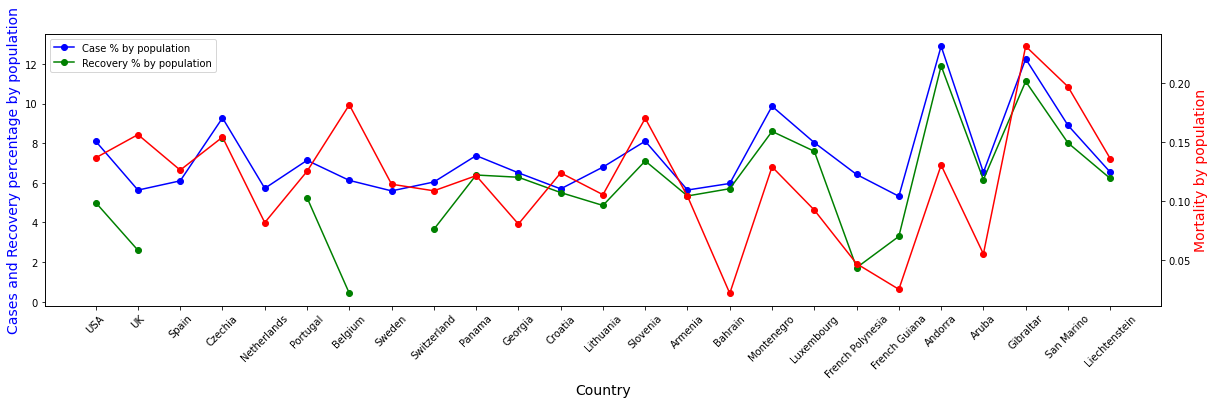

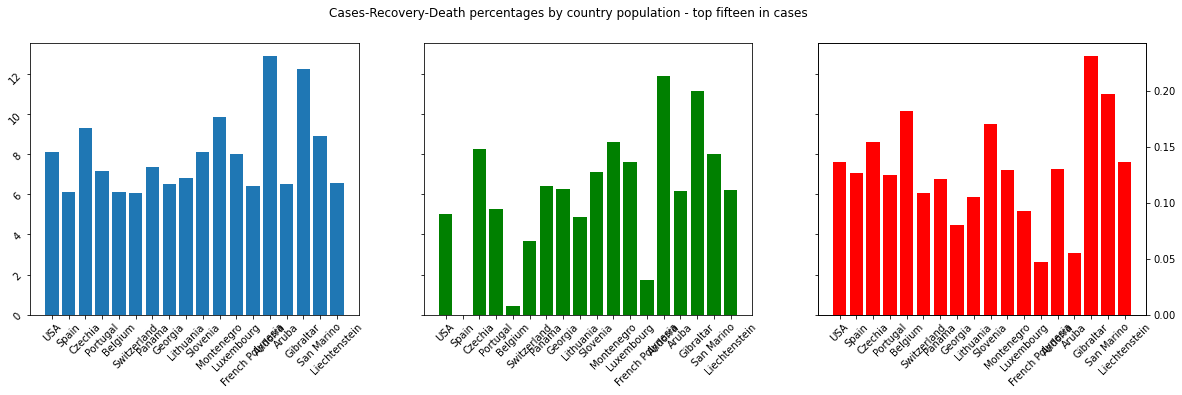

In [245]:
visualize(df)

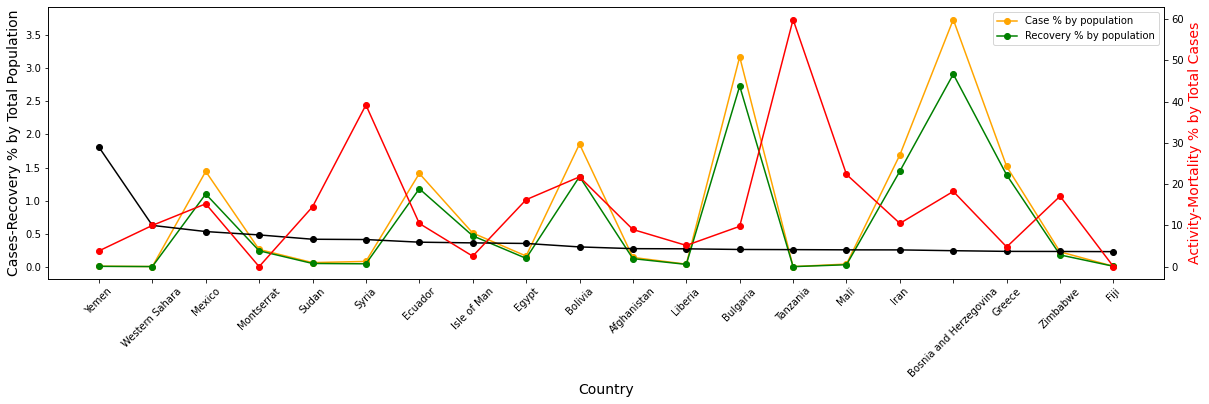

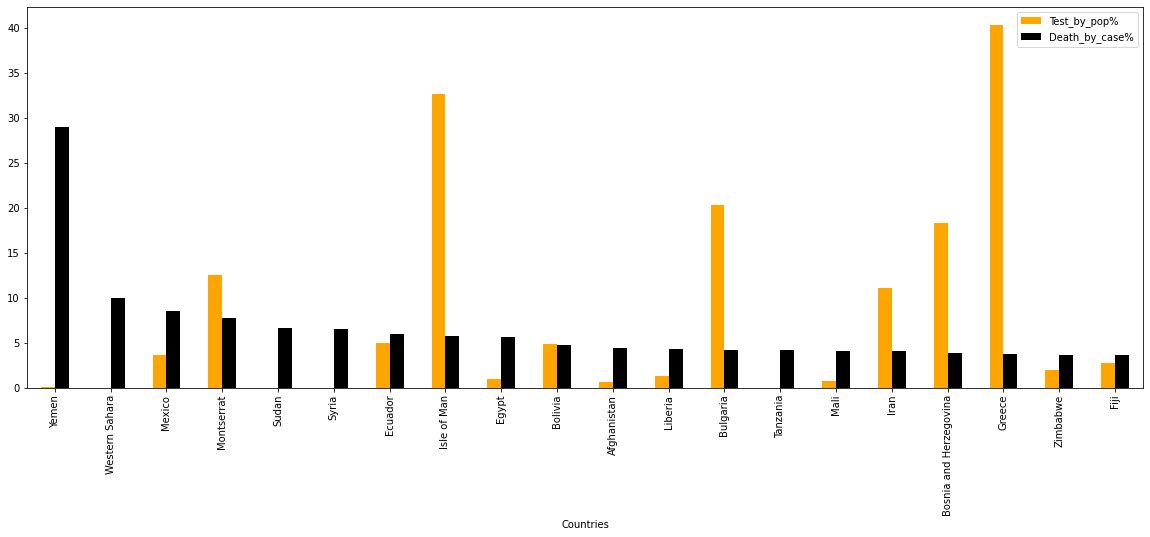

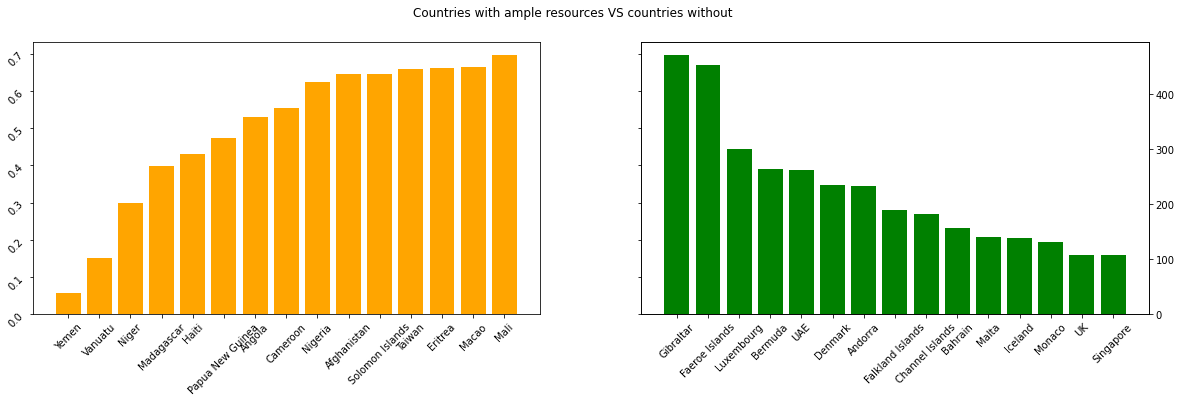

In [271]:
active_cases(df)

## Playing with widgets and interactives
### If like me, you don't like looking at visuals and prefer to dive deep into datasets, I find widgets quite handy for quick glances

In [232]:
#Lets create an interactive that wil take us through the dataset as we like
#We can choose by country or column metrics
#This cell creates a dropdown list of countries from our df and adds an "All" to it (in case we want the whole df)
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

In [272]:
#Create dropdown
dropdown_country = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df.Countries))

#Create Output widget for chosen country from the dropdown
output_country = widgets.Output()

#Create function to build sliders to dive deeper into the data
#This function allows us to view data by a range within column to identify what countries fall in the column
def dropdown_country_eventhandler(change):
    output_country.clear_output()
    with output_country:
        if (change.new == ALL):
            @interact
            def greater_than_population(column=df.columns[14:20], 
                                        P = (800, 1387049203, 500000), T = (0,500,0.5), D = (0,0.2,0.01), O = (0,50,0.5)):
                if column == 'Total_population':
                    return df.loc[df[column] > P]
                elif column == 'Test_by_pop%':
                    return df.loc[df[column] > T]
                elif column == 'Death_by_pop%':
                    return df.loc[df[column] > D]
                else:
                    return df.loc[df[column] > O]
        else:
            display(df[df['Countries'] == change.new])
        
dropdown_country.observe(dropdown_country_eventhandler, names='value')
display(dropdown_country)

Dropdown(options=('ALL', 'Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Ba…

In [273]:
display(output_country)

Output()